In [56]:
# % cd..
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import numpy as np

from scipy import signal
from scipy.signal import stft
from scipy.io import wavfile

import matplotlib.pyplot as plt

from env import *
from visualization import plot_spec

plt.style.use({'figure.facecolor':'white'})

981.8088030661817


""


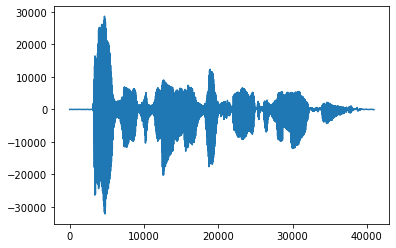

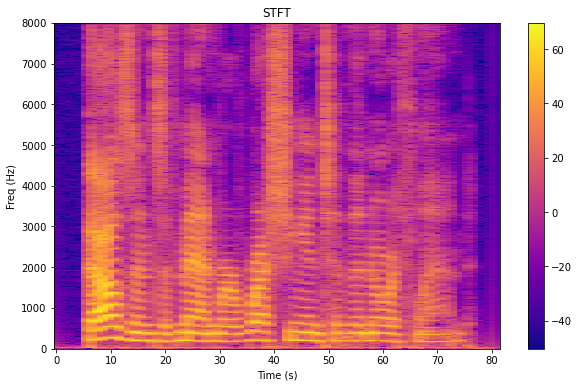

In [58]:
from scipy.fft import dct
from data import read_audio
from data.transform import db_to_amp
from data.metadata import vcc


def log_stft(amp, dynamic_range=120):
    """
    :param amp: amplitude
    :param dynamic_range: in db
    :return: time (1D array), frequencies (1D array), log amplitude
        log_amp is (num_freq, num_time) numpy array, in decibels

    Note on dynamic_range:
    -------
    Assuming that the weakest detectable sound is 0 db, then the loudest
    possible sound is 194 db.

    db = 20 * log_10(amp)
    """
    max_amp = np.max(amp)
    if max_amp == 0:
        return amp
    log_amp = 20 * np.log10(
        np.clip(amp, max_amp / db_to_amp(dynamic_range), np.inf))
    return log_amp


sr, dat = wavfile.read(vcc.train_2016(0, 2))
print(np.average(dat **2))

plt.figure()
plt.plot(dat)


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))




sound(dat)


def filter(log_amp, filter_size=10):
    if len(log_amp.shape) == 1:
        kernel = np.ones(filter_size) / filter_size
    else:
        kernel = np.ones((filter_size, 1)) / filter_size
    return signal.convolve(log_amp, kernel, mode='same')

from env import n_fft, n_hop
N_FFT = n_fft
freq, time, zxx = stft(dat, sr, nperseg=N_FFT, noverlap=N_FFT-n_hop)
amp = np.abs(zxx)
log_amp = log_stft(amp)
plot_spec(log_amp, freq=freq, title='STFT')

# from data.transform import mfcc_from_amp
# mfcc = mfcc_from_amp(amp, sr, n_mfcc=20)
# plot_spec(mfcc, title='MFCC')

In [59]:
envelope = filter(log_amp, filter_size=100)

# plot_spec(envelope, title='Envelope')

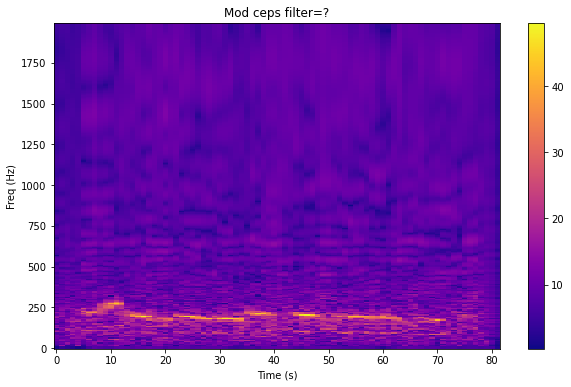

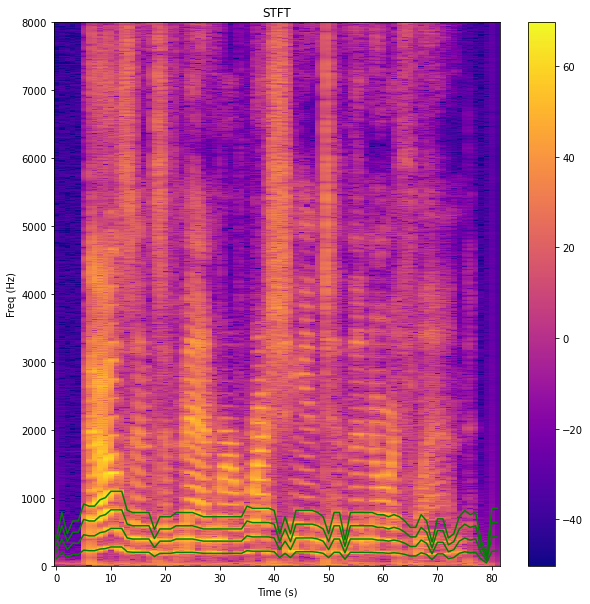

In [60]:
import data.transform.cepstrum as cepstrum

mod_ceps = cepstrum.mod_cepstrum(log_amp, filter_size=20)

plot_spec(np.sqrt(mod_ceps)[:256],freq=freq[:256],
          title='Mod ceps filter=?')

fundamental = np.argmax(mod_ceps, axis=0)

plot_spec(log_amp, freq=freq, title='STFT', figure_size=(10,10))
for i in range(1, 5):
    plt.plot(np.arange(log_amp.shape[1]), i*freq[fundamental], c='g')



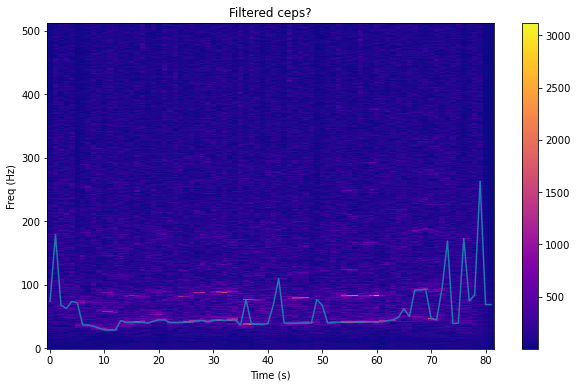

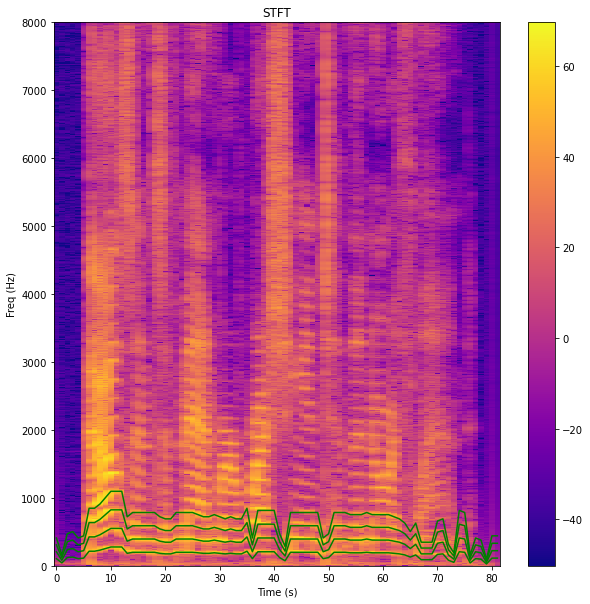

In [61]:
filtered_ceps = cepstrum.filtered_cepstrum(log_amp, kernel_size=20)

plot_spec(filtered_ceps,
          title='Filtered ceps?')

fundamental = np.argmax(filtered_ceps, axis=0)
plt.plot(fundamental)
plot_spec(log_amp, freq=freq, title='STFT', figure_size=(10,10))
for i in range(1, 5):
    plt.plot(np.arange(log_amp.shape[1]),
             i*freq[(frame_size / fundamental).astype(np.int8)], c='g')




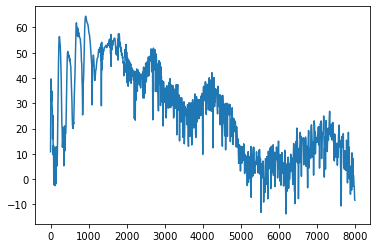

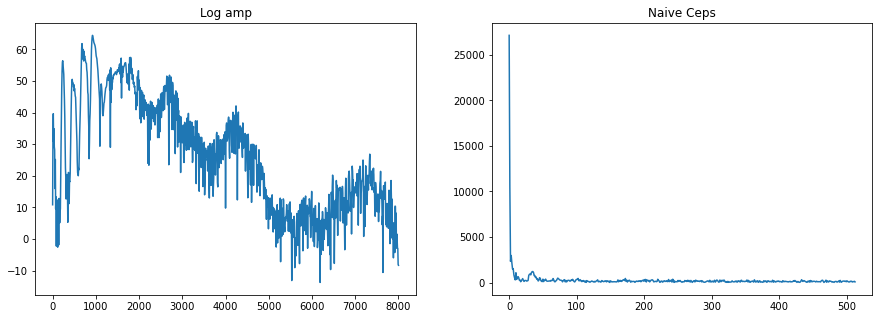

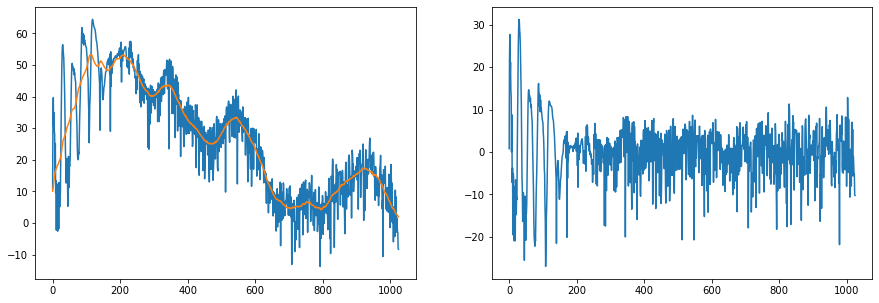

<Figure size 432x288 with 0 Axes>

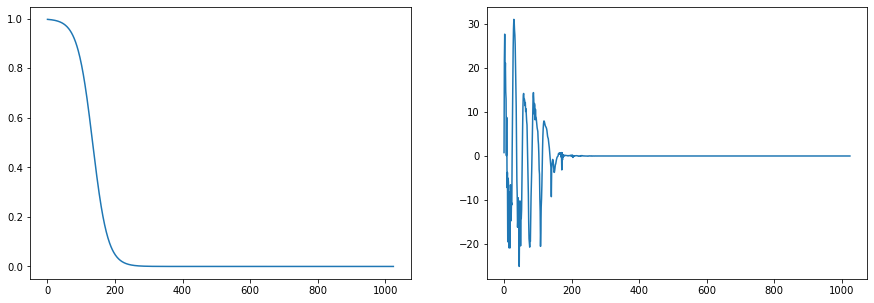

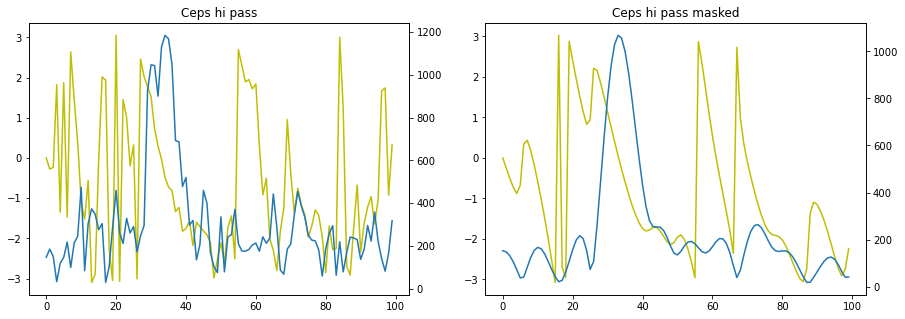

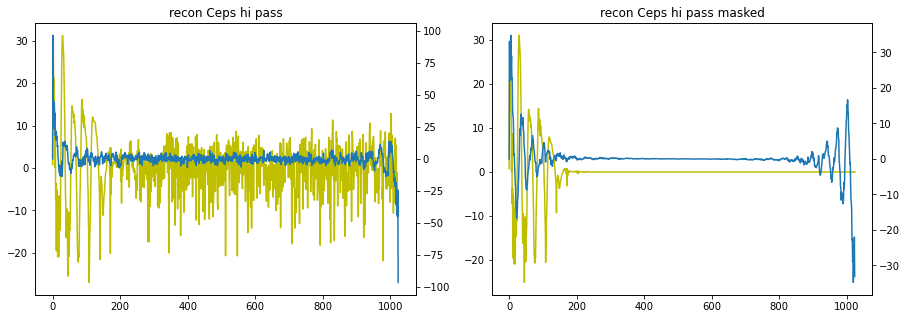

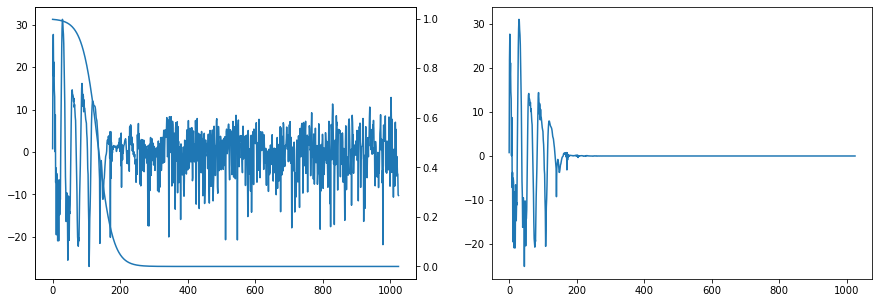

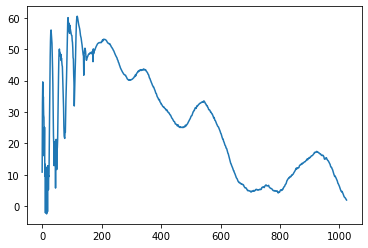

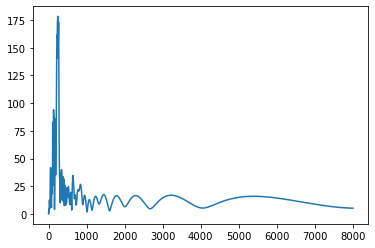

In [69]:

from numpy.fft import fft, rfft, ifft, irfft
from scipy.signal import convolve

t = 8
plt.figure()
frame = log_amp[:,t]

fn=freq.size
plt.plot(freq[:fn], frame[:fn])

def analyze(freq, frame):
    n = frame.size
    def filt(sig, size):
        return convolve(sig,  np.ones(size)/size, mode='same')
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.title('Log amp')
    plt.plot(freq, frame)
    plt.subplot(1,2,2)
    plt.title('Naive Ceps')
    plt.plot(np.abs(np.fft.rfft(frame)))


    filter_size = 60
    low_pass_filtered = convolve(
        frame,  np.ones(filter_size)/filter_size, mode='same')
    hi_pass_filtered = frame - low_pass_filtered

    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(frame)
    plt.plot(low_pass_filtered)
    plt.subplot(1,2,2)
    plt.plot(hi_pass_filtered)

    plt.figure()
    mask = 1/(1+np.e**(np.linspace(-6,40, num=n)))
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(mask)
    plt.subplot(1,2,2)
    plt.plot(hi_pass_filtered*mask)


    t = 100
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.title('Ceps hi pass')
    plt.plot(np.angle(np.fft.rfft(hi_pass_filtered))[:t], c='y')
    plt.twinx()
    plt.plot(np.abs(np.fft.rfft(hi_pass_filtered))[:t])
    plt.subplot(1,2,2)
    plt.title('Ceps hi pass masked')
    plt.plot(np.angle(np.fft.rfft(hi_pass_filtered * mask))[:t], c='y')
    plt.twinx()
    plt.plot(np.abs(np.fft.rfft(hi_pass_filtered * mask))[:t])
    # recon
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.title('recon Ceps hi pass')
    plt.plot(hi_pass_filtered, c='y')
    plt.twinx()
    plt.plot(np.fft.irfft(-1j*np.abs(np.fft.rfft(hi_pass_filtered))))
    plt.subplot(1,2,2)
    plt.title('recon Ceps hi pass masked')
    plt.plot(hi_pass_filtered * mask, c='y')
    plt.twinx()
    plt.plot(np.fft.irfft(-1j*np.abs(np.fft.rfft(hi_pass_filtered * mask))))


    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(hi_pass_filtered)
    plt.twinx()
    plt.plot(mask)
    plt.subplot(1,2,2)
    plt.plot(hi_pass_filtered * mask)

    plt.figure()
    plt.plot(hi_pass_filtered*mask+low_pass_filtered)

    plt.figure()
    ceps_in = hi_pass_filtered * mask
    ceps_in = filt(hi_pass_filtered, 10)
    mod_ceps = np.abs(cepstrum.mod_cepstrum(ceps_in))
    mod_ceps[0] = 0
    plt.plot(freq[:fn], mod_ceps)


analyze(freq[:fn], frame[:fn])


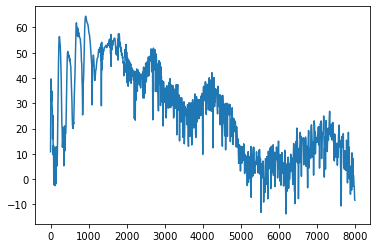

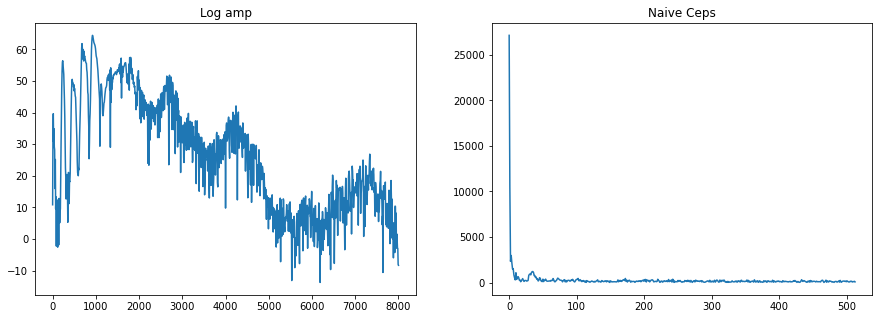

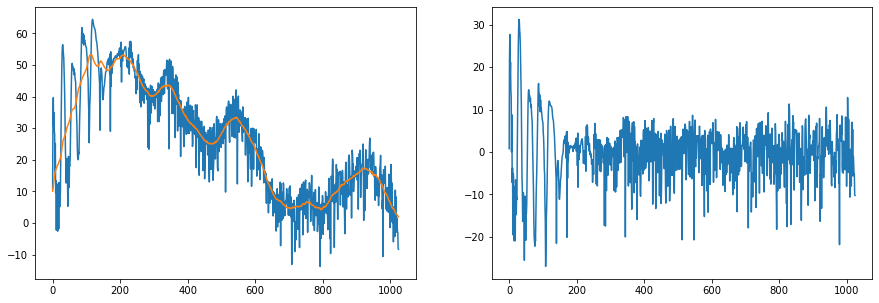

<Figure size 432x288 with 0 Axes>

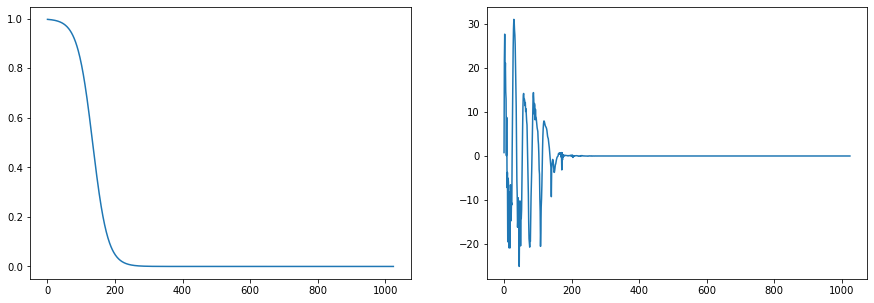

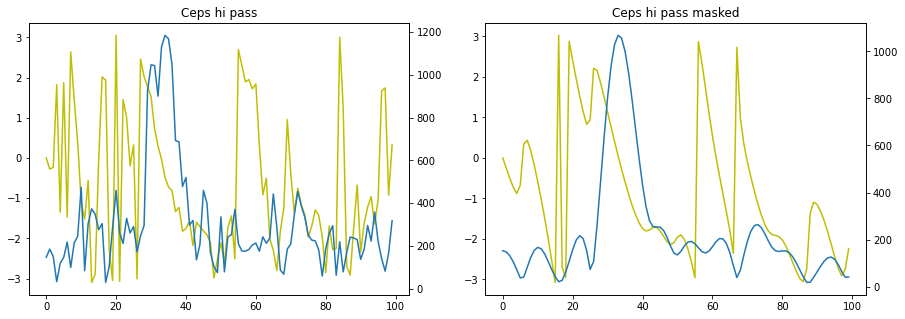

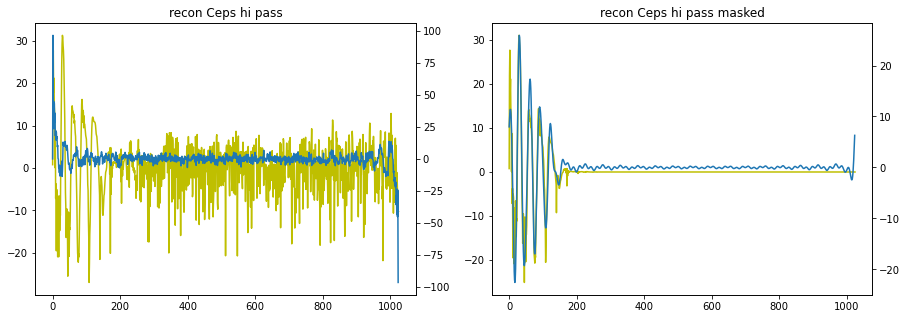

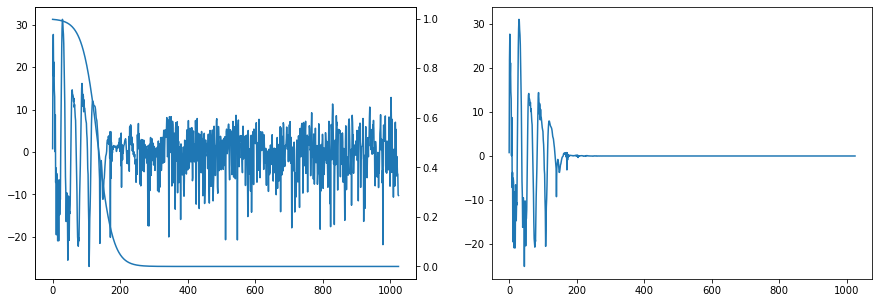

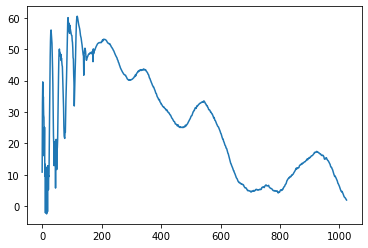

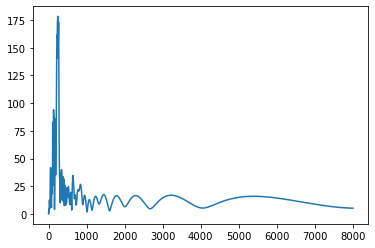

In [68]:

from numpy.fft import fft, rfft
from scipy.signal import convolve

t = 8
plt.figure()
frame = log_amp[:,t]

fn=freq.size
plt.plot(freq[:fn], frame[:fn])

def analyze(freq, frame):
    n = frame.size
    def filt(sig, size):
        return convolve(sig,  np.ones(size)/size, mode='same')
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.title('Log amp')
    plt.plot(freq, frame)
    plt.subplot(1,2,2)
    plt.title('Naive Ceps')
    plt.plot(np.abs(np.fft.rfft(frame)))


    filter_size = 60
    low_pass_filtered = convolve(
        frame,  np.ones(filter_size)/filter_size, mode='same')
    hi_pass_filtered = frame - low_pass_filtered

    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(frame)
    plt.plot(low_pass_filtered)
    plt.subplot(1,2,2)
    plt.plot(hi_pass_filtered)

    plt.figure()
    mask = 1/(1+np.e**(np.linspace(-6,40, num=n)))
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(mask)
    plt.subplot(1,2,2)
    plt.plot(hi_pass_filtered*mask)


    t = 100
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.title('Ceps hi pass')
    plt.plot(np.angle(np.fft.rfft(hi_pass_filtered))[:t], c='y')
    plt.twinx()
    plt.plot(np.abs(np.fft.rfft(hi_pass_filtered))[:t])
    plt.subplot(1,2,2)
    plt.title('Ceps hi pass masked')
    plt.plot(np.angle(np.fft.rfft(hi_pass_filtered * mask))[:t], c='y')
    plt.twinx()
    plt.plot(np.abs(np.fft.rfft(hi_pass_filtered * mask))[:t])
    # recon
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.title('recon Ceps hi pass')
    plt.plot(hi_pass_filtered, c='y')
    plt.twinx()
    plt.plot(np.fft.irfft(-1j*np.abs(np.fft.rfft(hi_pass_filtered))))
    plt.subplot(1,2,2)
    plt.title('recon Ceps hi pass masked')
    plt.plot(hi_pass_filtered * mask, c='y')
    plt.twinx()
    ceps = np.fft.rfft(hi_pass_filtered * mask)
    ceps[:20] = 0
    ceps[60:]  = 0
    plt.plot(np.fft.irfft(ceps))
    # plt.plot(np.fft.irfft(-1j*np.abs(np.fft.rfft(hi_pass_filtered * mask))))




    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(hi_pass_filtered)
    plt.twinx()
    plt.plot(mask)
    plt.subplot(1,2,2)
    plt.plot(hi_pass_filtered * mask)

    plt.figure()
    plt.plot(hi_pass_filtered*mask+low_pass_filtered)

    plt.figure()
    ceps_in = hi_pass_filtered * mask
    ceps_in = filt(hi_pass_filtered, 10)
    mod_ceps = np.abs(cepstrum.mod_cepstrum(ceps_in))
    mod_ceps[0] = 0
    plt.plot(freq[:fn], mod_ceps)


analyze(freq[:fn], frame[:fn])


""


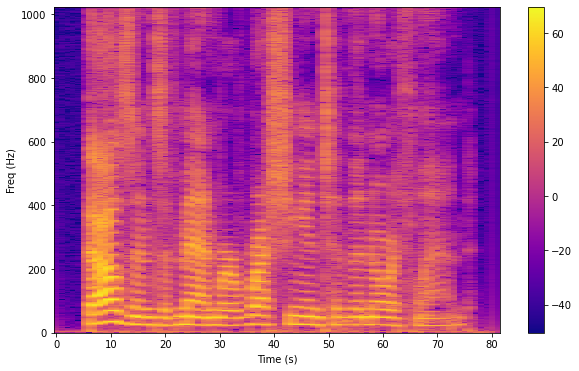

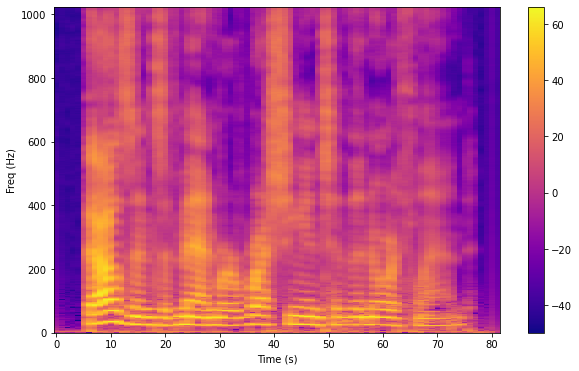

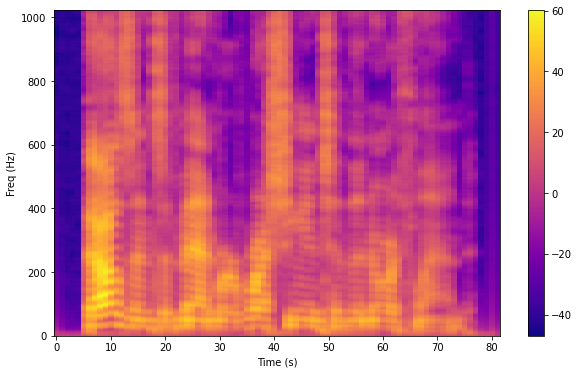

In [63]:
import data

from data.transform import mean_filter
from vocoder import griffin_lim
n = log_amp.shape[0]
formant = mean_filter(log_amp, 20)
hi = log_amp - formant
mask = 1/(1+np.e**(np.linspace(-6,40, num=n)))
# mask = np.ones(n)

recon = formant+hi * mask.reshape((-1, 1))
plot_spec(log_amp)
plot_spec(recon)
plot_spec(formant)
db_to_amp(recon)
sound(griffin_lim(db_to_amp(recon)))

""


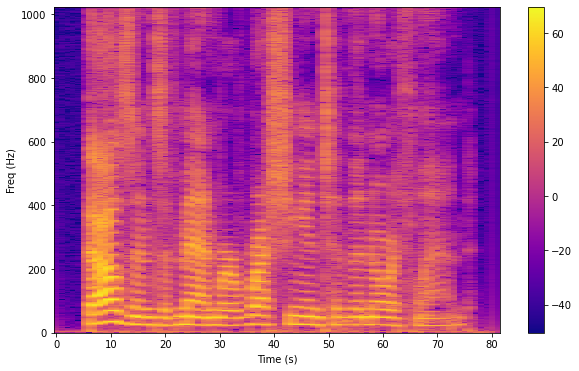

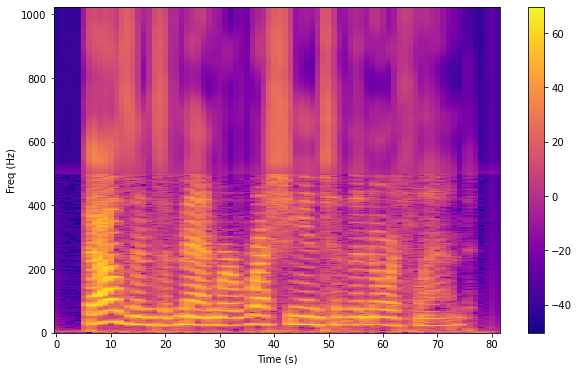

In [64]:
from data.transform import mean_filter
from vocoder import griffin_lim
recon = log_amp.copy()
l = 500
recon[l:] = mean_filter(recon[l:], 80)
# n = log_amp.shape[0]
# formant = mean_filter(log_amp, 20)
# hi = log_amp - formant
# mask = 1/(1+np.e**(np.linspace(-6,40, num=n)))
# mask = np.ones(n)

# recon = formant+hi * mask.reshape((-1, 1))
plot_spec(log_amp)
plot_spec(recon)
# plot_spec(formant)
# db_to_amp(recon)
sound(griffin_lim(db_to_amp(recon)))

(1025, 82)


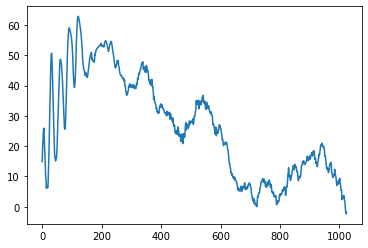

In [65]:
low_pass_filtered = convolve(log_amp, np.ones((10, 1))/10, mode='same')
print(low_pass_filtered.shape)
plt.figure()
plt.plot(low_pass_filtered[:,t])

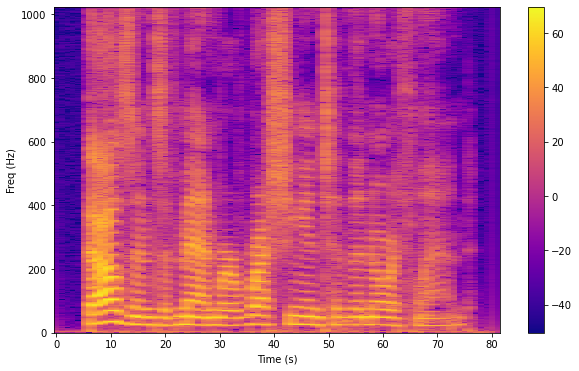

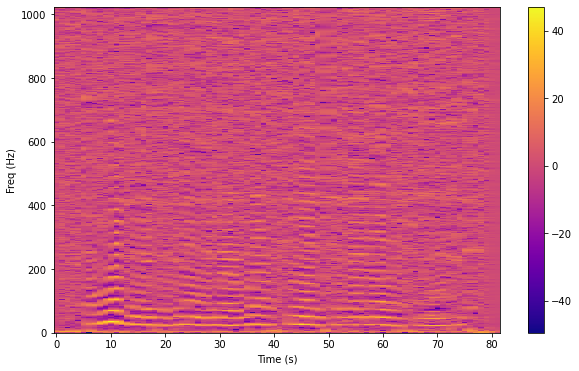

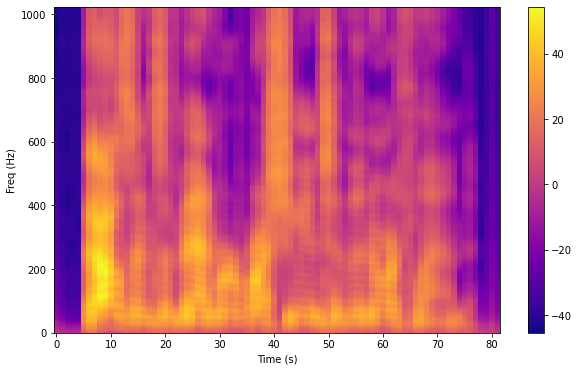

In [66]:
from data.transform import mean_filter
from vocoder import griffin_lim
recon = log_amp.copy()
lo = mean_filter(log_amp, 60)
hi = log_amp-lo
# n = log_amp.shape[0]
# formant = mean_filter(log_amp, 20)
# hi = log_amp - formant
# mask = 1/(1+np.e**(np.linspace(-6,40, num=n)))
# mask = np.ones(n)

# recon = formant+hi * mask.reshape((-1, 1))
plot_spec(log_amp)
plot_spec(hi)
plot_spec(lo)
# plot_spec(formant)
# db_to_amp(recon)
# sound(griffin_lim(db_to_amp(hi)))

""


(1025, 82)


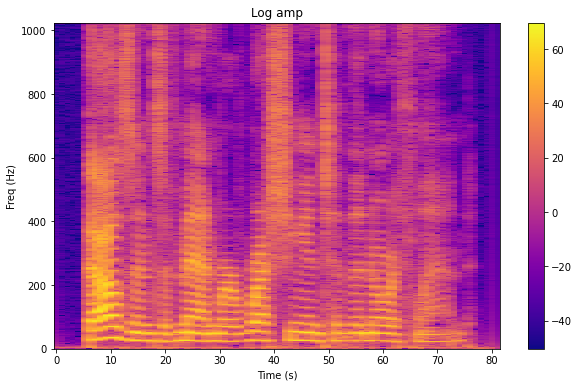

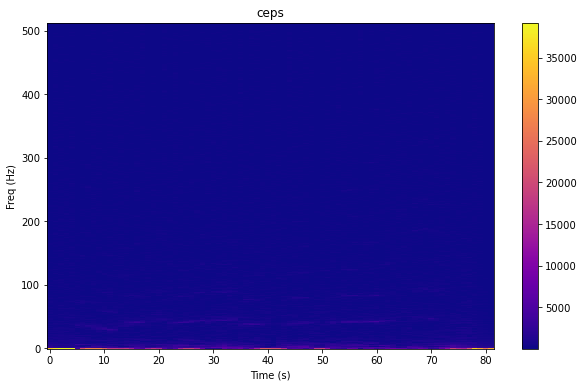

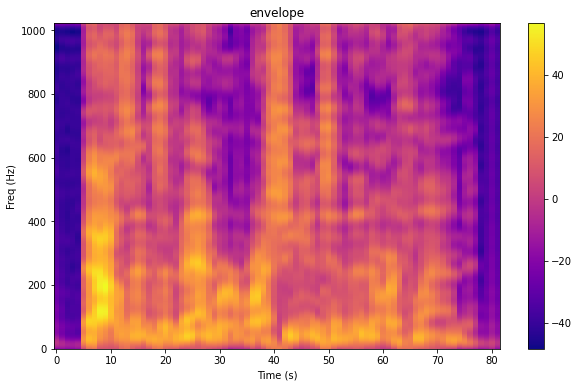

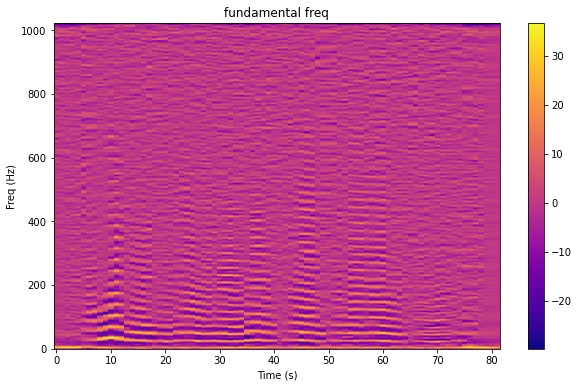

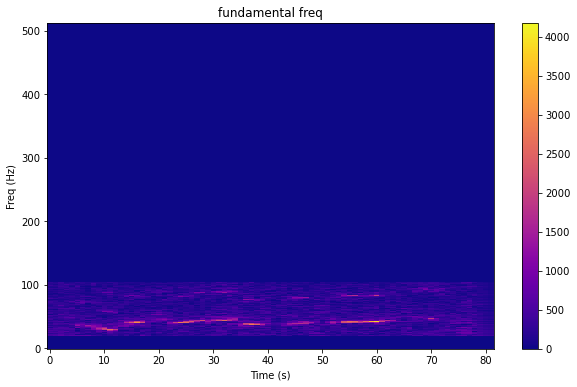

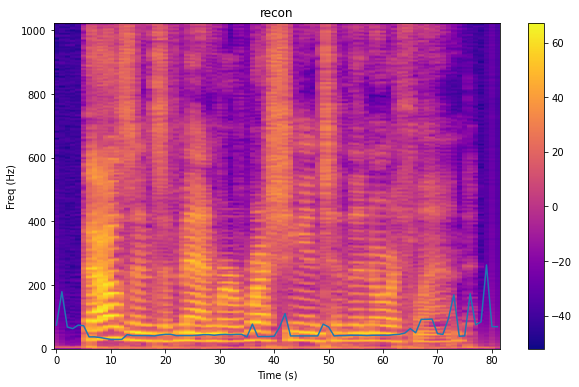

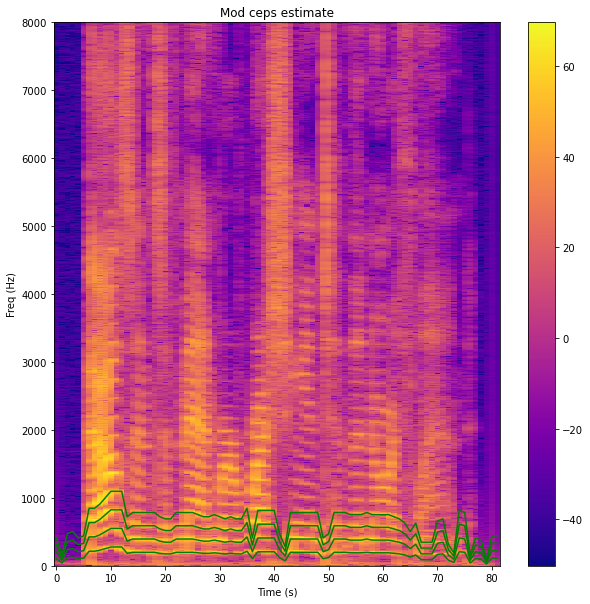

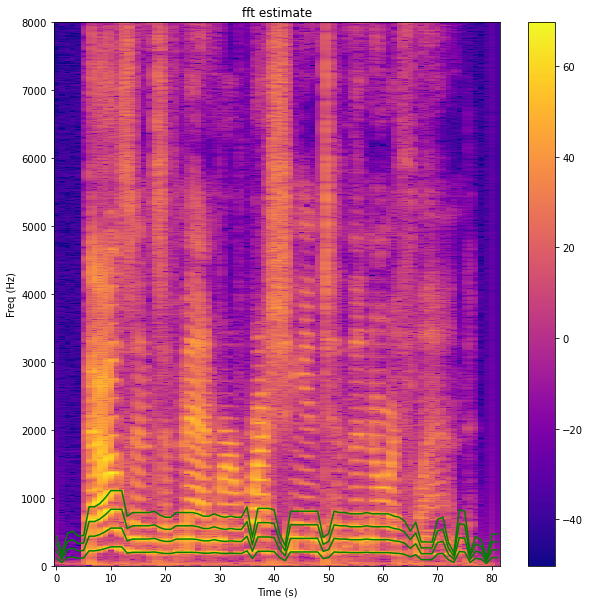

In [85]:
sound(griffin_lim(db_to_amp(log_amp)))

plot_spec(log_amp, title='Log amp')

c_ceps = rfft(log_amp, axis=0)
plot_spec(np.abs(c_ceps), title='ceps')


lo_ceps = c_ceps.copy()
lo_ceps[20:] = 0
lo_recon = irfft(lo_ceps, axis=0)
plot_spec(lo_recon, title='envelope')

hi_ceps = c_ceps.copy()
hi_ceps[:20] = 0
hi_ceps[105:] = 0
hi_recon = irfft(hi_ceps, axis=0)
plot_spec(hi_recon, title='fundamental freq')
plot_spec(np.abs(rfft(hi_recon, axis=0)), title='fundamental freq')

recon = np.zeros_like(log_amp)
recon[:lo_recon.shape[0]] = lo_recon +hi_recon
# recon = lo_recon + hi_recon

plot_spec(recon, title='recon')
print(recon.shape)
# sound(griffin_lim(db_to_amp(recon)))

filtered_ceps = cepstrum.filtered_cepstrum(log_amp, kernel_size=20)
fundamental = np.argmax(filtered_ceps, axis=0)
fund_freq = freq[(frame_size / fundamental).astype(np.int8)]
plt.plot(fundamental)
plot_spec(log_amp, freq=freq, title='Mod ceps estimate', figure_size=(10,10))
for i in range(1, 5):
    plt.plot(np.arange(log_amp.shape[1]),
             i*freq[(frame_size / fundamental).astype(np.int8)], c='g')

filtered = mean_filter(log_amp, 20)
estimated = np.abs(np.fft.rfft(filtered))
fundamental = np.argmax(filtered_ceps, axis=0)
# fund_freq = freq[(frame_size / fundamental).astype(np.int8)]
fund_freq = sr /2/ fundamental
plot_spec(log_amp, freq=freq, title='fft estimate', figure_size=(10,10))
for i in range(1, 5):
    plt.plot(np.arange(log_amp.shape[1]),
             i*fund_freq, c='g')

# conclusion: fundamental freq = sr / 2 / ceps_bin_index,
# if using rfft for stft and ceps

In [67]:
# from IPython.core.display import Javascript
#
# color = colorpicker.value
# Javascript("""
# let div = document.getElementById('color');
# document.body.style.backgroundColor = "{}";
# """.format(color))
#